Amatya Pathak       
December 9, 2025       
CSCA 5632 Unsupervised Algorithms in Machine Learning

# Final Project: Clustering Leukemia Variations Based on Gene Expression Data

<hr>

## 0: Project Objective

The objective of this project is to explore gene expression data for two types of cancer: acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL). Then, we will create supervised models to assign an unknown cancerous gene to the right category (class prediction), as well as unsupervised clustering models to sort a group of random cancerous genes into statistically significant categories (class discovery).

<hr>

## 1: Importing Dependencies & Loading Datasets

In [32]:
import os

#DataFrame and Graph Visualization Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, silhouette_score, accuracy_score, make_scorer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

This project's primary dataset is sourced from the Broad Institute’s Cancer Program Legacy Publication Resources, and the raw data contains 7129 genes (rows) with 76 expression samples each (columns). All rows but only 38 of these columns are relevant, because we also have a second dataset file containing 72 rows (of which 38 are relevant) and 11 columns (of which 2 are relevant). The 38 rows of the secondary dataset correspond to the 38 columns of the primary dataset. The extra data in both files means we have some cleaning to do.

But first, we downloaded the TSV file containing the primary dataset and the CSV containing the secondary dataset, and loaded them both as pandas dataframes:

In [3]:
df = pd.read_csv("AMLTrainingDataset.tsv", sep='\t', header= 0, index_col=False)
print("Primary Dataset Info(): ",df.info()) 
print("\nPrimary Dataset Describe():\n", df.describe())
print("\nPrimary Dataset Shape: ",df.shape)
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 78 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Gene Description       7129 non-null   object
 1   Gene Accession Number  7129 non-null   object
 2   1                      7129 non-null   int64 
 3   call                   7129 non-null   object
 4   2                      7129 non-null   int64 
 5   call.1                 7129 non-null   object
 6   3                      7129 non-null   int64 
 7   call.2                 7129 non-null   object
 8   4                      7129 non-null   int64 
 9   call.3                 7129 non-null   object
 10  5                      7129 non-null   int64 
 11  call.4                 7129 non-null   object
 12  6                      7129 non-null   int64 
 13  call.5                 7129 non-null   object
 14  7                      7129 non-null   int64 
 15  call.6               

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A
5,AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-5_at,-558,A,-400,A,-650,A,-585,A,...,-155,A,-344,A,-508,A,-423,A,-566,A
6,AFFX-BioDn-3_at (endogenous control),AFFX-BioDn-3_at,199,A,-330,A,33,A,158,A,...,29,A,324,A,-349,A,-31,A,-141,A
7,AFFX-CreX-5_at (endogenous control),AFFX-CreX-5_at,-176,A,-168,A,-367,A,-253,A,...,-105,A,-237,A,-194,A,-223,A,-315,A
8,AFFX-CreX-3_at (endogenous control),AFFX-CreX-3_at,252,A,101,A,206,A,49,A,...,42,A,105,A,34,A,-82,A,206,A
9,AFFX-BioB-5_st (endogenous control),AFFX-BioB-5_st,206,A,74,A,-215,A,31,A,...,524,A,167,A,-56,A,176,A,321,A


In [4]:
metadata_df = pd.read_csv("AMLSamples.csv", sep=',', header= 0, index_col=False)
print(metadata_df.shape)
main_metadata_df = metadata_df.head(38) # note we only need the first 38 columns
main_metadata_df # and the first 2 columns

(72, 11)


,Samples,ALL_AML,BM/PB,T_B-cell,FAB,Date,Gender,percent_blasts,treatment_response,PS,Source
0,1,ALL,BM,B-cell,NaN,9/4/96,M,NaN,NaN,1.00,DFCI
1,2,ALL,BM,T-cell,NaN,NaN,M,NaN,NaN,0.41,DFCI
2,3,ALL,BM,T-cell,NaN,NaN,M,NaN,NaN,0.87,DFCI
3,4,ALL,BM,B-cell,NaN,NaN,NaN,NaN,NaN,0.91,DFCI
4,5,ALL,BM,B-cell,NaN,NaN,NaN,NaN,NaN,0.89,DFCI
5,6,ALL,BM,T-cell,NaN,NaN,M,NaN,NaN,0.76,DFCI
6,7,ALL,BM,B-cell,NaN,3/25/83,F,NaN,NaN,0.78,DFCI
7,8,ALL,BM,B-cell,NaN,NaN,F,NaN,NaN,0.77,DFCI
8,9,ALL,BM,T-cell,NaN,NaN,M,NaN,NaN,0.89,DFCI
9,10,ALL,BM,T-cell,NaN,7/23/87,M,NaN,NaN,0.56,DFCI


## 2: Exploratory Data Analysis (EDA)

Let's start cleaning the primary dataset! Duplicates and colunns in the "Call.n" format are not relevant to our project, and as shown below, the "Gene Description" column has duplicates while the "Gene Accession Number" is unique for all rows.

So let's remove "Call.n" style columns, set our primary key (for indexing the primary dataset) to be the "Gene Accession Number", and remove the "Gene Description Column":

In [5]:
# Dropping call.n containing columns
df = df.loc[:, ~df.columns.str.startswith('call')]
print(df.shape)
df.head(5)

# How many duplicate entries for these columns?
print(df[df["Gene Accession Number"].duplicated() == True].shape[0], "duplicate Gene Accession Numbers")
print(df[df["Gene Description"].duplicated() == True].shape[0], "duplicate Gene Descriptions")

# Changing dataframe's primary key to "Gene Accession Number"
genes_df = df[["Gene Accession Number", "Gene Description"]]
df = df.set_index("Gene Accession Number")
# Removing "Gene Description" from main dataframe
df = df.drop(["Gene Description"], axis=1)
df.head(10)

(7129, 40)
0 duplicate Gene Accession Numbers
502 duplicate Gene Descriptions


,1,2,3,4,5,6,7,8,9,10,...,35,36,37,38,28,29,30,31,32,33
Gene Accession Number,,,,,,,,,,,,,,,,,,,,,
AFFX-BioB-5_at,-214,-139,-76,-135,-106,-138,-72,-413,5,-88,...,7,-213,-25,-72,-4,15,-318,-32,-124,-135
AFFX-BioB-M_at,-153,-73,-49,-114,-125,-85,-144,-260,-127,-105,...,-100,-252,-20,-139,-116,-114,-192,-49,-79,-186
AFFX-BioB-3_at,-58,-1,-307,265,-76,215,238,7,106,42,...,-57,136,124,-1,-125,2,-95,49,-37,-70
AFFX-BioC-5_at,88,283,309,12,168,71,55,-2,268,219,...,132,318,325,392,241,193,312,230,330,337
AFFX-BioC-3_at,-295,-264,-376,-419,-230,-272,-399,-541,-210,-178,...,-377,-209,-396,-324,-191,-51,-139,-367,-188,-407
AFFX-BioDn-5_at,-558,-400,-650,-585,-284,-558,-551,-790,-535,-246,...,-478,-557,-464,-510,-411,-155,-344,-508,-423,-566
AFFX-BioDn-3_at,199,-330,33,158,4,67,131,-275,0,328,...,-351,40,-221,-350,-31,29,324,-349,-31,-141
AFFX-CreX-5_at,-176,-168,-367,-253,-122,-186,-179,-463,-174,-148,...,-290,-243,-390,-202,-240,-105,-237,-194,-223,-315
AFFX-CreX-3_at,252,101,206,49,70,87,126,70,24,177,...,283,119,-1,249,150,42,105,34,-82,206


Now we can z-score normalize each expression value in the dataset since they exist on different scales. 

After we do that, we take the first 2 columns of the secondary dataset: the sample number and the type of leukemia that sample represents: AML or ALL. 

And we map them to our primary dataset to get mean expression value and standard deviation of every gene for both AML and AML samples.

In [6]:
# Creating 2 lists of indexes in secondary dataset, one for ALL and one for AML (then casting as str) 
all_list = main_metadata_df[main_metadata_df['ALL_AML'].isin(["ALL"])]["Samples"].tolist()
aml_list = main_metadata_df[main_metadata_df['ALL_AML'].isin(["AML"])]["Samples"].tolist()

all_list = [str(x) for x in all_list] 
aml_list = [str(x) for x in aml_list]

# Z-score normalization
df["STD"] = df.std(axis = 1)
df["Mean"] = df.mean(axis = 1)

for col in df.columns:
    df[col] = (df[col] - df['Mean'])/df["STD"]

print(df.mean(axis = 1), "\n")
print(df.std(axis=1))
df = df.drop(columns = ["Mean", "STD"])

# Mapping secondary dataset columns (sample number and leukemia type) to primary dataset:
df[['all_mean', 'all_std']] = df[all_list].agg(
    ['mean', 'std'], axis=1
)
df[['aml_mean', 'aml_std']] = df[aml_list].agg(
    ['mean', 'std'], axis=1
)
print(df.shape)
df.head()

Gene Accession Number
AFFX-BioB-5_at    9.992007e-17
AFFX-BioB-M_at   -2.220446e-17
AFFX-BioB-3_at    4.996004e-17
AFFX-BioC-5_at    3.885781e-17
AFFX-BioC-3_at   -1.110223e-17
                      ...     
X83863_at        -1.665335e-17
Z17240_at         3.885781e-17
L49218_f_at       2.636780e-17
M71243_f_at      -7.216450e-17
Z78285_f_at       4.440892e-17
Length: 7129, dtype: float64 

Gene Accession Number
AFFX-BioB-5_at    1.029193
AFFX-BioB-M_at    1.082455
AFFX-BioB-3_at    0.990716
AFFX-BioC-5_at    0.977812
AFFX-BioC-3_at    1.119490
                    ...   
X83863_at         0.982229
Z17240_at         0.978636
L49218_f_at       0.975906
M71243_f_at       0.975236
Z78285_f_at       1.021474
Length: 7129, dtype: float64
(7129, 42)


,1,2,3,4,5,6,7,8,9,10,...,28,29,30,31,32,33,all_mean,all_std,aml_mean,aml_std
Gene Accession Number,,,,,,,,,,,,,,,,,,,,,
AFFX-BioB-5_at,-0.904014,-0.219431,0.355619,-0.182920,0.081786,-0.210303,0.392130,-2.720443,1.094970,0.246086,...,1.012820,1.186247,-1.853304,0.757242,-0.082514,-0.182920,-0.192047,1.000267,0.285087,0.959521
AFFX-BioB-M_at,-0.109266,0.947055,1.263952,0.405690,0.260446,0.788607,0.009570,-1.522097,0.234038,0.524527,...,0.379282,0.405690,-0.624223,1.263952,0.867831,-0.544999,-0.175287,1.024666,0.165617,0.937724
AFFX-BioB-3_at,-0.376422,0.107917,-2.492219,2.368166,-0.529371,1.943307,2.138742,0.175895,1.017115,0.473296,...,-0.945733,0.133409,-0.690817,0.532776,-0.197981,-0.478388,-0.049753,1.105847,0.020628,0.718744
AFFX-BioC-5_at,-0.781111,0.878915,1.100252,-1.428096,-0.100075,-0.925832,-1.062039,-1.547277,0.751221,0.334086,...,0.521371,0.112749,1.125791,0.427728,1.279024,1.338615,-0.274748,0.940812,0.722586,0.788194
AFFX-BioC-3_at,-0.255708,0.023560,-0.985409,-1.372781,0.329854,-0.048509,-1.192608,-2.471836,0.510027,0.798304,...,0.681191,1.942402,1.149641,-0.904331,0.708217,-1.264677,-0.097556,0.977346,-0.069802,1.102662


With the gene expression values z-score normalized, we can perform a t-test and sort the primary dataframe to get the most expressed genes for AML and ALL (top 25 for each):

In [7]:
def welch_t_test(row):
    return ((row['all_mean'] - row['aml_mean']) / np.sqrt(row['all_std']/len(all_list) + row['aml_std']/len(aml_list)))
df['t_testresults'] = df[['all_mean', 'all_std', 'aml_mean', 'aml_std']].apply(welch_t_test, axis=1)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,all_mean,all_std,aml_mean,aml_std,t_testresults
Gene Accession Number,,,,,,,,,,,,,,,,,,,,,
AFFX-BioB-5_at,-0.904014,-0.219431,0.355619,-0.182920,0.081786,-0.210303,0.392130,-2.720443,1.094970,0.246086,...,1.186247,-1.853304,0.757242,-0.082514,-0.182920,-0.192047,1.000267,0.285087,0.959521,-1.353463
AFFX-BioB-M_at,-0.109266,0.947055,1.263952,0.405690,0.260446,0.788607,0.009570,-1.522097,0.234038,0.524527,...,0.405690,-0.624223,1.263952,0.867831,-0.544999,-0.175287,1.024666,0.165617,0.937724,-0.971247
AFFX-BioB-3_at,-0.376422,0.107917,-2.492219,2.368166,-0.529371,1.943307,2.138742,0.175895,1.017115,0.473296,...,0.133409,-0.690817,0.532776,-0.197981,-0.478388,-0.049753,1.105847,0.020628,0.718744,-0.215870
AFFX-BioC-5_at,-0.781111,0.878915,1.100252,-1.428096,-0.100075,-0.925832,-1.062039,-1.547277,0.751221,0.334086,...,0.112749,1.125791,0.427728,1.279024,1.338615,-0.274748,0.940812,0.722586,0.788194,-3.056105
AFFX-BioC-3_at,-0.255708,0.023560,-0.985409,-1.372781,0.329854,-0.048509,-1.192608,-2.471836,0.510027,0.798304,...,1.942402,1.149641,-0.904331,0.708217,-1.264677,-0.097556,0.977346,-0.069802,1.102662,-0.075137


In [8]:
# Sorting by t-test results, then dropping the columns used to calculate it for simplicity
df_sorted = df.sort_values('t_testresults', ascending = False).drop(columns=['all_mean', 'all_std', 'aml_mean', 'aml_std', 't_testresults'])

In [9]:
all_markers = df[df.index.isin(df["t_testresults"].sort_values(ascending = False).head(25).index.tolist())]
aml_markers = df[df.index.isin(df["t_testresults"].sort_values(ascending = False).tail(25).index.tolist())]

top50_markers = all_markers._append(aml_markers)

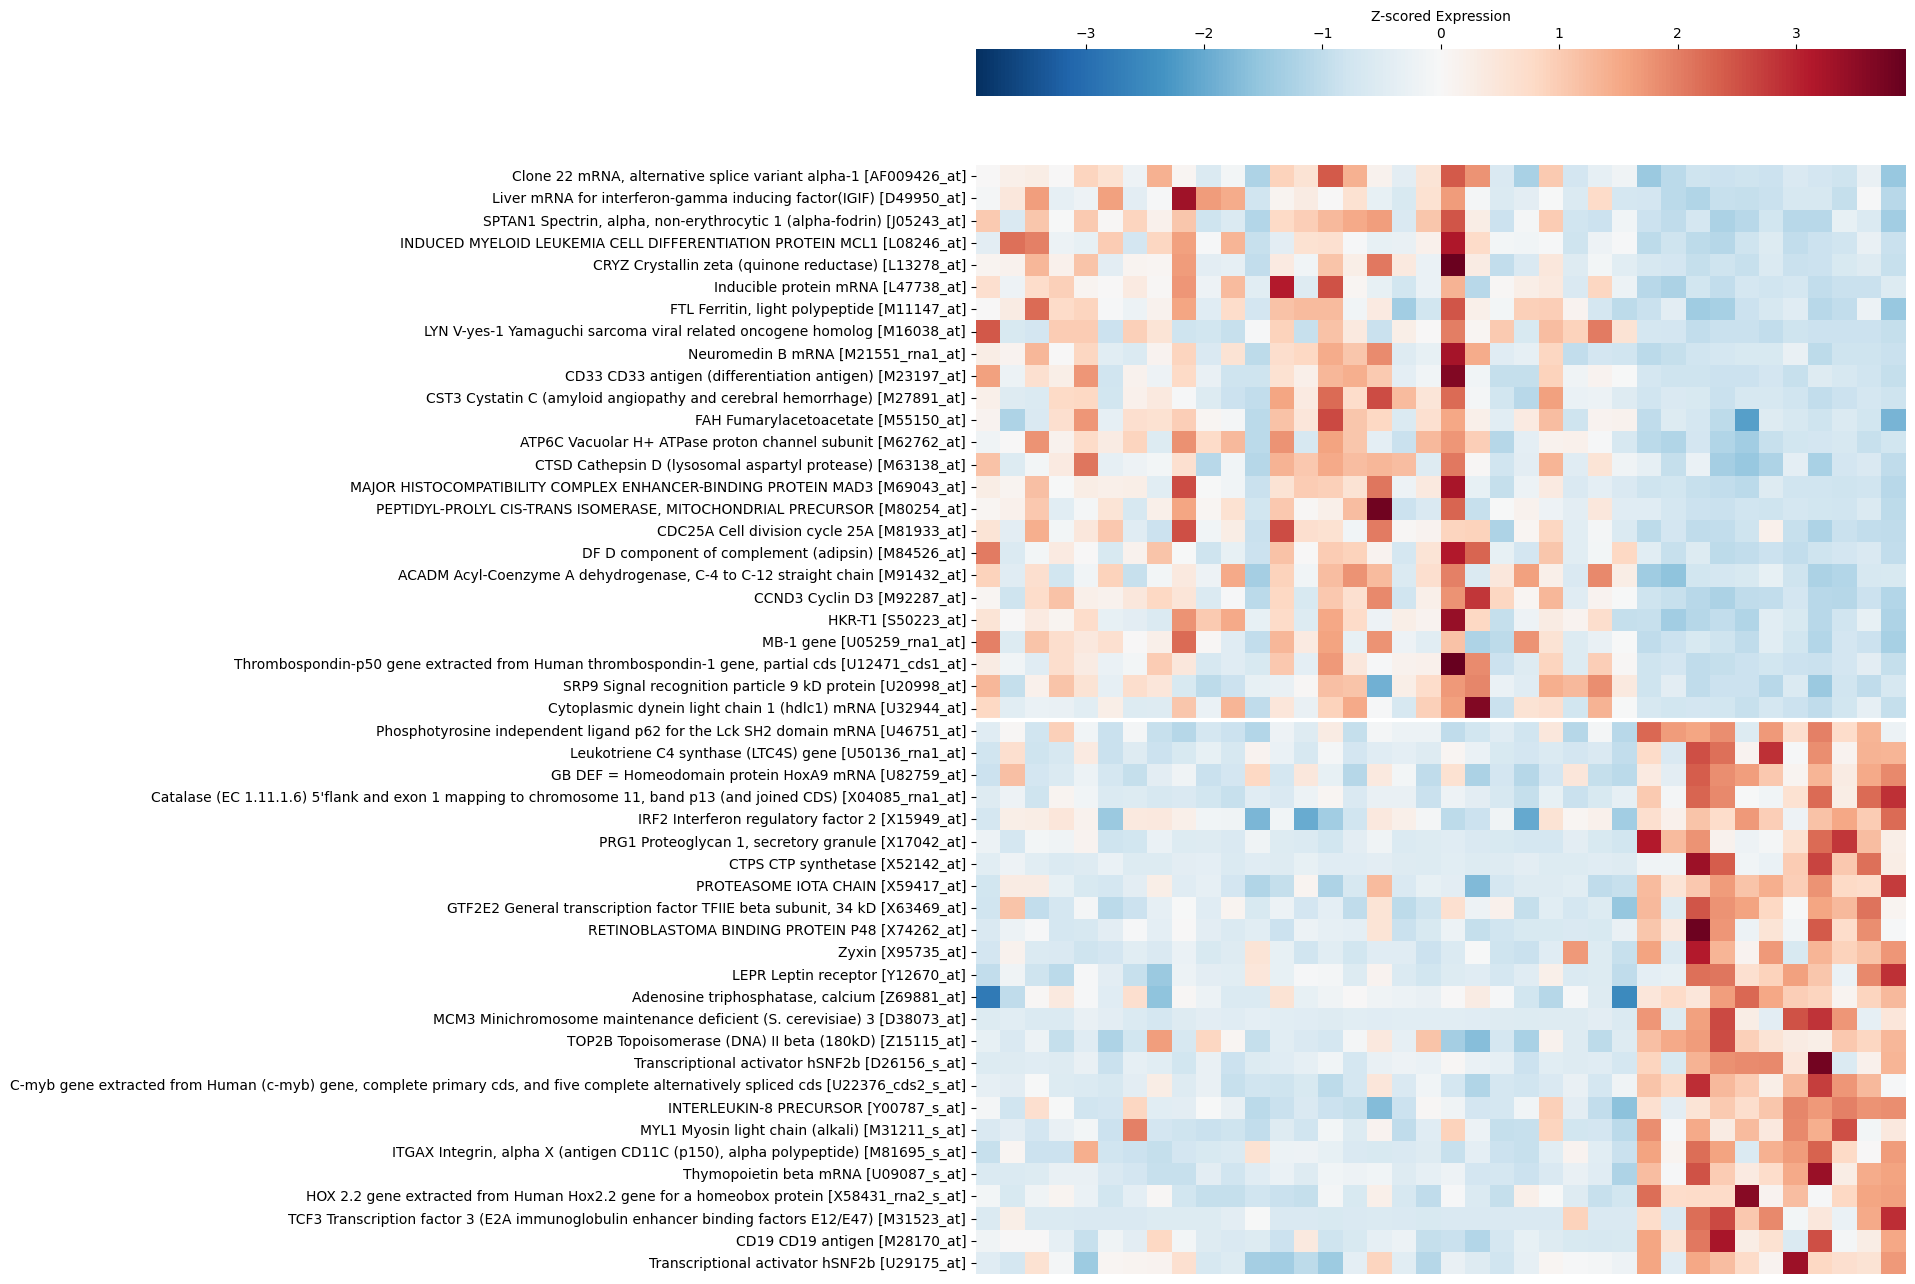

In [10]:
top50_markers = top50_markers.drop(columns = ["all_mean", "all_std", "aml_mean", "aml_std", "t_testresults"])
genes_df["combo"] = genes_df["Gene Description"] + " [" + genes_df["Gene Accession Number"] + "]" # making gene description + accession number
top50_markers.index = genes_df[genes_df["Gene Accession Number"].isin(top50_markers.index.tolist())]["combo"].tolist()

fig = plt.figure()
ax = sns.heatmap(data=top50_markers, yticklabels=True, xticklabels=False, cmap="RdBu_r", center = 0, vmin = -(top50_markers.to_numpy().max()), vmax = top50_markers.to_numpy().max(), cbar_kws = dict(use_gridspec=False,location="top", label='Z-scored Expression'))
ax.set_ylabel("")
ax.axhline(25, 0, 1, linewidth=3, c='w')
fig.set_size_inches(12, 18)
plt.show()

## 3: Supervised Learning Model Development

Before doing unsupervised learning, we'll get a baseline expectation of performance by training a model with the top 50 genes correlated with ALL or AML.

We utilize logistic regression to accomplish this task with a 2:1 train:test split. We will only change the solver to liblinear, leaving all other hyperparameters as default

In [11]:
# 1 row = 1 sample, so transpose df 
top50_markers = top50_markers.transpose()
top50_markers.head()

top50_all = top50_markers[top50_markers.index.isin(all_list)]
top50_aml = top50_markers[top50_markers.index.isin(aml_list)]

# One-hot encoding ALL and AML to 0 and 1 respectively
top50_all["label_code"] = 0
top50_aml["label_code"] = 1
top50 = top50_all._append(top50_aml)
print(top50.shape)

(38, 51)


C:\Users\Amatya Pathak\AppData\Local\Temp\ipykernel_10288\713608966.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top50_all["label_code"] = 0
C:\Users\Amatya Pathak\AppData\Local\Temp\ipykernel_10288\713608966.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top50_aml["label_code"] = 1


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    top50.drop(columns=['label_code']), 
    top50['label_code'], 
    test_size=0.33, 
    random_state=42)

In [13]:
# create a new logistic regression model
lr = LogisticRegression(random_state=42, solver='liblinear')
# train the model using the training data
clf = lr.fit(X_train, y_train)
# now that the model has been trained, predict the classes in the test set
pred = clf.predict(X_test)
# predict outputs labels, decision_function outputs the confidence scores
y_scores = clf.decision_function(X_test)
# print the accuracy sum(predicted == actual) / len(labels)
print('Predicted Class:\t', pred)
print('Actual Class: \t\t', y_test.to_numpy())
y_scores

Predicted Class:	 [1 1 0 0 1 0 0 1 0 0 0 0 0]
Actual Class: 		 [1 1 0 0 1 0 0 1 0 0 0 0 0]


array([ 6.16956829,  6.62204045, -2.6328753 , -3.14917564, 10.14300836,
       -4.93445859, -1.72694459,  8.38203294, -2.04785274, -4.32721343,
       -2.46889213, -5.03609058, -0.42127347])

In [14]:
# scoring the model will return the accuracy using test features and labels
print(clf.score(X_test, y_test)) # score of 1

1.0


It seems that for the top 50 genes, the model correctly classified every single gene as AML or ALL correctly! The confusion matrix below also reflects that:

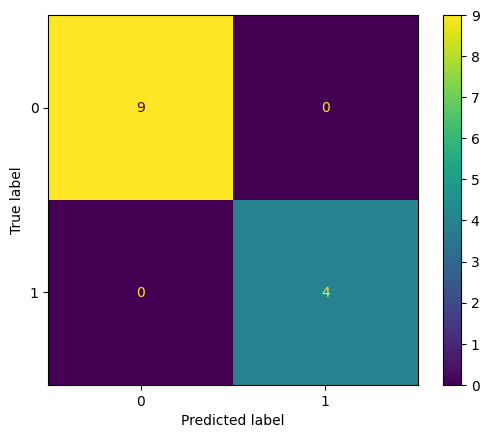

In [15]:
cm = confusion_matrix(y_test, pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot()
plt.show()


Let's also implement Leave One Out Cross-Validation to ascertain the strength of our predictions.

In [16]:
# Leave one out cross validation using scikit

# Create a new LeaveOneOut object and assign it to loo
loo = LeaveOneOut()
# Calculate the number of splits, this uses the number of rows in the features set
loo.get_n_splits(top50)

max_probs = []
clf_scores_list = []

# loo.split(features) will return column indexes for train and test sets
# . the train will have len(samples) -1 elements
# . the test set will contain a single index
for train_index, test_index in loo.split(top50):
    # split the data into train and test sets using the indicies
    top50, 
    top50,
    X_train = top50.iloc[train_index].drop(columns=['label_code'])
    X_test = top50.iloc[test_index].drop(columns=['label_code'])
    y_train = top50.iloc[train_index]['label_code']
    y_test = top50.iloc[test_index]['label_code']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='liblinear')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    # print the accuracy of the model using the test set
    print(clf.score(X_test, y_test), end=', ') # model was 100% accurate for all conditions
    clf_scores_list.append(clf.score(X_test, y_test))
    # this will output the probilites per test case
    #   as we only have one test we can use zero to index it
    max_probs.append(max(clf.predict_proba(X_test)[0]))

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [17]:
sum(clf_scores_list)/len(clf_scores_list) # 100% accuracy across LOO cross-validation

1.0

In [18]:
probs_df = pd.DataFrame({'Number of genes':["50"] * 38,
                          'Prediction Strength':max_probs})


C:\Users\Amatya Pathak\AppData\Local\Temp\ipykernel_10288\3410955524.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


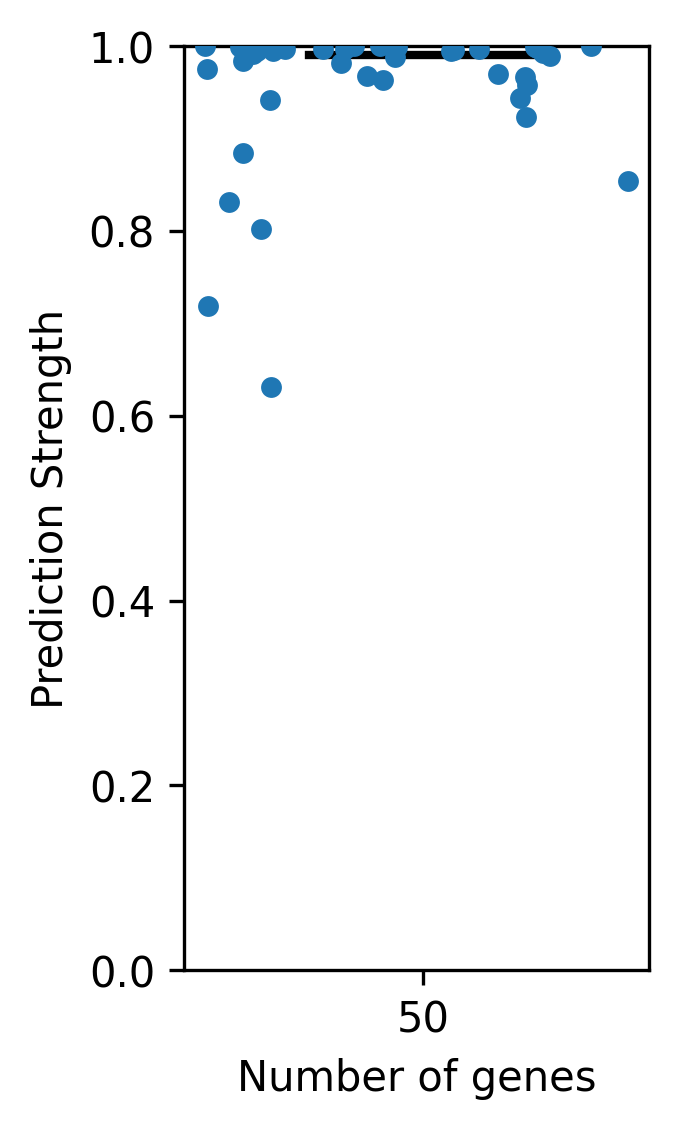

In [19]:
fig = plt.figure(figsize=(2, 4), dpi=300)
ax = sns.stripplot(x = probs_df["Number of genes"], y = probs_df["Prediction Strength"], orient='v')
plt.ylim(0, 1.00)

# 
median_width = 0.1

for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()): # add median line
  sample_name = text.get_text()  # "X" or "Y"

  median_val = probs_df[probs_df['Number of genes']==sample_name]["Prediction Strength"].median()

  ax.plot([tick-median_width/2, tick+median_width/2], [median_val, median_val],
                lw=2, color='k')

fig.show()


With a few outliers, many of our predictions appear confident as well as correct! 

Let's see if this holds true if we repeat this Logistic Regression model fitting and Leave One Out Cross-Validation to classify less or more genes as AML/ALL, ranging from the top 2 genes to the top 100:

In [20]:
# repeat with different numbers of top genes: (top 2, 10, 100)

# first let's generate the dataframes for the top 2, 10, and 100 genes; 

# top 2
all_markers = df[df.index.isin(df["t_testresults"].sort_values(ascending = False).head(1).index.tolist())]
aml_markers = df[df.index.isin(df["t_testresults"].sort_values(ascending = False).tail(1).index.tolist())]

top2_markers = all_markers._append(aml_markers)
top2_markers.index.tolist()

# top 10
all_markers = df[df.index.isin(df["t_testresults"].sort_values(ascending = False).head(5).index.tolist())]
aml_markers = df[df.index.isin(df["t_testresults"].sort_values(ascending = False).tail(5).index.tolist())]

top10_markers = all_markers._append(aml_markers)
top10_markers.index.tolist()

# top 20
all_markers = df[df.index.isin(df["t_testresults"].sort_values(ascending = False).head(10).index.tolist())]
aml_markers = df[df.index.isin(df["t_testresults"].sort_values(ascending = False).tail(10).index.tolist())]

top20_markers = all_markers._append(aml_markers)
top20_markers.index.tolist()

# top 100
all_markers = df[df.index.isin(df["t_testresults"].sort_values(ascending = False).head(50).index.tolist())]
aml_markers = df[df.index.isin(df["t_testresults"].sort_values(ascending = False).tail(50).index.tolist())]

top100_markers = all_markers._append(aml_markers)
top100_markers.index.tolist()

['AF009426_at',
 'D63874_at',
 'D63880_at',
 'D86967_at',
 'D88270_at',
 'HG1612-HT1612_at',
 'J03473_at',
 'J05243_at',
 'L13278_at',
 'L47738_at',
 'M11722_at',
 'M13792_at',
 'M29696_at',
 'M31303_rna1_at',
 'M77142_at',
 'M86406_at',
 'M91432_at',
 'M92287_at',
 'S50223_at',
 'U05259_rna1_at',
 'U20998_at',
 'U32944_at',
 'U35451_at',
 'U62136_at',
 'U72342_at',
 'X15414_at',
 'X15949_at',
 'X52142_at',
 'X56411_rna1_at',
 'X59417_at',
 'X63469_at',
 'X74262_at',
 'X76648_at',
 'Y08612_at',
 'Z69881_at',
 'D38073_at',
 'M61853_at',
 'Z15115_at',
 'AF012024_s_at',
 'D26156_s_at',
 'U22376_cds2_s_at',
 'M84371_rna1_s_at',
 'M31211_s_at',
 'U09087_s_at',
 'U26266_s_at',
 'X97267_rna1_s_at',
 'L49229_f_at',
 'M31523_at',
 'M28170_at',
 'U29175_at',
 'D14874_at',
 'D49950_at',
 'L08246_at',
 'L20941_at',
 'L38608_at',
 'M11147_at',
 'M16038_at',
 'M21551_rna1_at',
 'M22960_at',
 'M23197_at',
 'M27891_at',
 'M37435_at',
 'M55150_at',
 'M57710_at',
 'M62762_at',
 'M63138_at',
 'M69043_at'

In [21]:
# top 2
top2_markers = top2_markers.transpose()
top2_markers.head()

top2_all = top2_markers[top2_markers.index.isin(all_list)]
top2_aml = top2_markers[top2_markers.index.isin(aml_list)]

top2_all["label_code"] = 0
top2_aml["label_code"] = 1

top2 = top2_all._append(top2_aml)
print(top2.shape)

# top 10
top10_markers = top10_markers.transpose()
top10_markers.head()

top10_all = top10_markers[top10_markers.index.isin(all_list)]
top10_aml = top10_markers[top10_markers.index.isin(aml_list)]

top10_all["label_code"] = 0
top10_aml["label_code"] = 1

top10 = top10_all._append(top10_aml)
print(top10.shape)

#top 20
top20_markers = top20_markers.transpose()
top20_markers.head()

top20_all = top20_markers[top20_markers.index.isin(all_list)]
top20_aml = top20_markers[top20_markers.index.isin(aml_list)]

top20_all["label_code"] = 0
top20_aml["label_code"] = 1

top20 = top20_all._append(top20_aml)
print(top20.shape)

# top 100
top100_markers = top100_markers.transpose()
top100_markers.head()

top100_all = top100_markers[top100_markers.index.isin(all_list)]
top100_aml = top100_markers[top100_markers.index.isin(aml_list)]

top100_all["label_code"] = 0
top100_aml["label_code"] = 1

top100 = top100_all._append(top100_aml)
print(top100.shape)

(38, 3)
(38, 11)
(38, 21)
(38, 101)


C:\Users\Amatya Pathak\AppData\Local\Temp\ipykernel_10288\3109871178.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top2_all["label_code"] = 0
C:\Users\Amatya Pathak\AppData\Local\Temp\ipykernel_10288\3109871178.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top2_aml["label_code"] = 1
C:\Users\Amatya Pathak\AppData\Local\Temp\ipykernel_10288\3109871178.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [22]:
#### TOP 2 MARKERS

loo = LeaveOneOut()
loo.get_n_splits(top2)

max_probs_top2 = []
clf_scores_list_top2 = []

for train_index, test_index in loo.split(top2):
    top2, 
    top2,
    X_train = top2.iloc[train_index].drop(columns=['label_code'])
    X_test = top2.iloc[test_index].drop(columns=['label_code'])
    y_train = top2.iloc[train_index]['label_code']
    y_test = top2.iloc[test_index]['label_code']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='liblinear')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    print(clf.score(X_test, y_test), end=', ') # 
    clf_scores_list_top2.append(clf.score(X_test, y_test))

    max_probs_top2.append(max(clf.predict_proba(X_test)[0]))

1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [23]:
#### TOP 10 MARKERS

loo = LeaveOneOut()
loo.get_n_splits(top10)

max_probs_top10 = []
clf_scores_list_top10 = []

for train_index, test_index in loo.split(top10):
    top10, 
    top10,
    X_train = top10.iloc[train_index].drop(columns=['label_code'])
    X_test = top10.iloc[test_index].drop(columns=['label_code'])
    y_train = top10.iloc[train_index]['label_code']
    y_test = top10.iloc[test_index]['label_code']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='liblinear')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    print(clf.score(X_test, y_test), end=', ') # 
    clf_scores_list_top10.append(clf.score(X_test, y_test))

    max_probs_top10.append(max(clf.predict_proba(X_test)[0]))

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [24]:
#### TOP 20 MARKERS

loo = LeaveOneOut()
loo.get_n_splits(top20)

max_probs_top20 = []
clf_scores_list_top20 = []

for train_index, test_index in loo.split(top20):
    top20, 
    top20,
    X_train = top20.iloc[train_index].drop(columns=['label_code'])
    X_test = top20.iloc[test_index].drop(columns=['label_code'])
    y_train = top20.iloc[train_index]['label_code']
    y_test = top20.iloc[test_index]['label_code']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='liblinear')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    print(clf.score(X_test, y_test), end=', ') # 
    clf_scores_list_top20.append(clf.score(X_test, y_test))

    max_probs_top20.append(max(clf.predict_proba(X_test)[0]))

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [25]:
#### TOP 100 MARKERS

loo = LeaveOneOut()
loo.get_n_splits(top100)

max_probs_top100 = []
clf_scores_list_top100 = []


for train_index, test_index in loo.split(top100):
    top100, 
    top100,
    X_train = top100.iloc[train_index].drop(columns=['label_code'])
    X_test = top100.iloc[test_index].drop(columns=['label_code'])
    y_train = top100.iloc[train_index]['label_code']
    y_test = top100.iloc[test_index]['label_code']
    
    lr = LogisticRegression(solver='liblinear')
    clf = lr.fit(X_train, y_train)
    print(clf.score(X_test, y_test), end=', ') # 
    clf_scores_list_top100.append(clf.score(X_test, y_test))
    max_probs_top100.append(max(clf.predict_proba(X_test)[0]))

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [26]:
print(sum(clf_scores_list_top2)/len(clf_scores_list_top2)) # 97% accurate (missed 1/38) 
print(sum(clf_scores_list_top10)/len(clf_scores_list_top10)) # 100% accurate (missed 0/38) 
print(sum(clf_scores_list)/len(clf_scores_list)) # 100% accurate (missed 0/38) 
print(sum(clf_scores_list_top100)/len(clf_scores_list_top100)) # 100% accurate (missed 0/38) 

percent_accuracy = [sum(clf_scores_list_top2)/len(clf_scores_list_top2), sum(clf_scores_list_top10)/len(clf_scores_list_top10),
 sum(clf_scores_list)/len(clf_scores_list), sum(clf_scores_list_top100)/len(clf_scores_list_top100)]


0.9736842105263158
1.0
1.0
1.0


In [27]:
probs_df = pd.DataFrame({'Number of genes':["2"] * 38 + ["10"] * 38 + ["50"] * 38 + ["100"] * 38, 
                          'Prediction Strength': max_probs_top2 + max_probs_top10 + max_probs + max_probs_top100})

C:\Users\Amatya Pathak\AppData\Local\Temp\ipykernel_10288\254152025.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


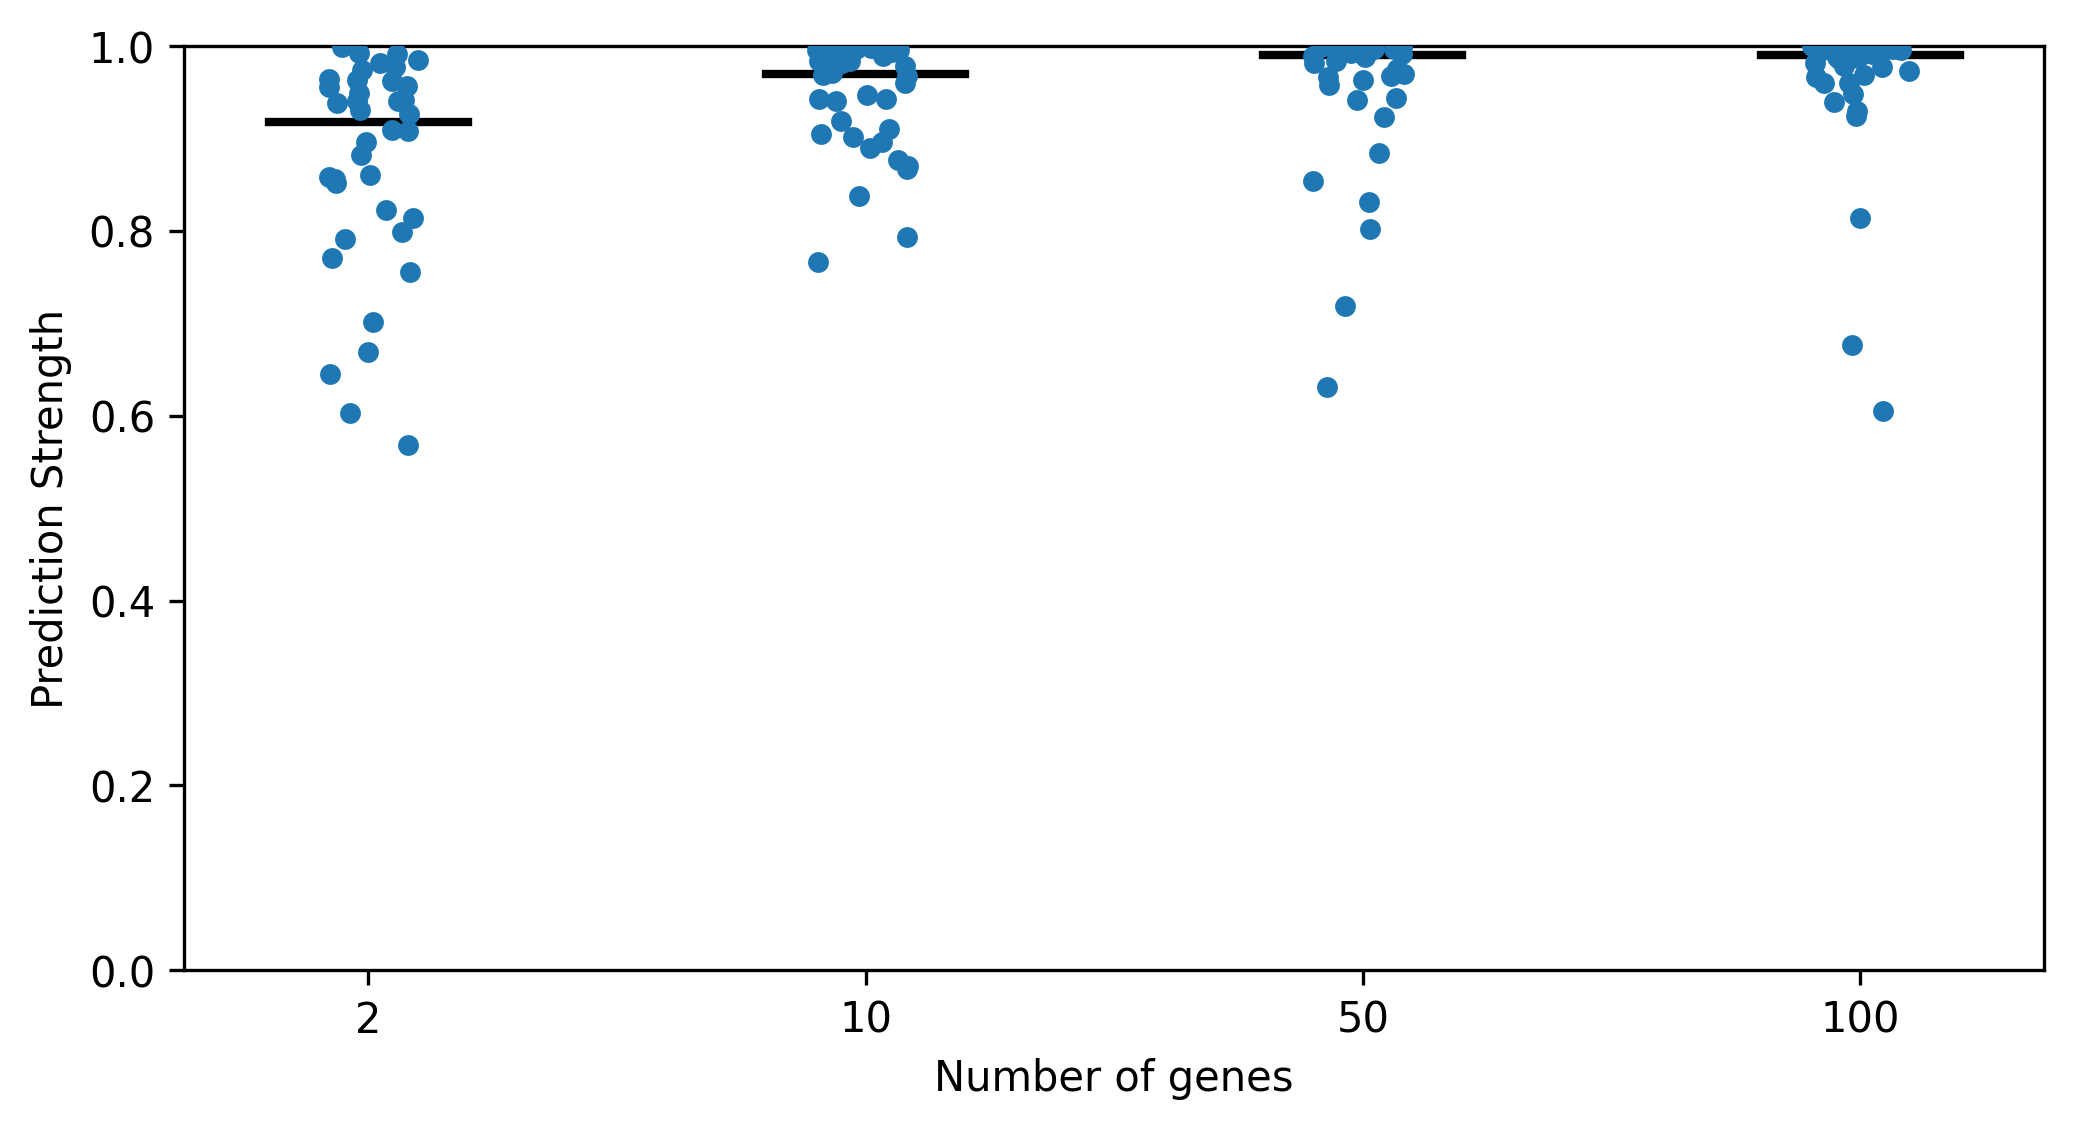

In [28]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = sns.stripplot(x = probs_df["Number of genes"], y = probs_df["Prediction Strength"], orient='v')
plt.ylim(0, 1.00)
median_width = 0.4
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()): # add median line
  sample_name = text.get_text()  # "X" or "Y"
  median_val = probs_df[probs_df['Number of genes']==sample_name]["Prediction Strength"].median()
  ax.plot([tick-median_width/2, tick+median_width/2], [median_val, median_val], lw=2, color='k')

fig.show()

There is a noticeable decrease in performance for the top 2 genes due to the limited data, but otherwise there seems to be a positive direct correlation between amount of data and the average prediction strength (represented by the black bars)

And now that we have thoroughly examined how supervised learning can tackle the task of grouping AML and ALL genes, let's move on to unsupervised learning!

## 4: Unsupervised Learning Model Development
Here we will start with k-means clustering to predict classes in using the 38 features in our primary dataset, and determine if we can independently derive ALL and AML classes. 

Once again, we one-hot encode ALL to be 0 and AML to be 1 for the models to interpret.

In [29]:
df = df.transpose()
df.head()

df_all = df[df.index.isin(all_list)]
df_aml = df[df.index.isin(aml_list)]

df_all["label_code"] = 0
df_aml["label_code"] = 1

df = df_all._append(df_aml)
print(df.shape)


(38, 7130)


C:\Users\Amatya Pathak\AppData\Local\Temp\ipykernel_10288\1024796451.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all["label_code"] = 0
C:\Users\Amatya Pathak\AppData\Local\Temp\ipykernel_10288\1024796451.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aml["label_code"] = 1


And we separate that AML/ALL label column from the other features; our unsupervised ML models should only know that there are 2 clusters and it should independently derive the same AML and ALL groups.

In [30]:
# extract the expression levels as features from df
features = df.drop(columns=['label_code']).values
labels = df['label_code'].values
print('features:', features.shape)
print('labels:', labels.shape)

features: (38, 7129)
labels: (38,)


Let's try k-means clustering first, and simultaneously optimize its hyperparameters with GridSearchCV so it performs best (quantifiable by both accuracy and a silhouette score to ensure the best clusters were found):

In [31]:
kmc = KMeans()

paramgrid = {
    'n_clusters': [2],
    'init': ['k-means++', 'random'],
    'n_init': ['auto', 10, 20, 50],
    'random_state': [42]
}

grid = GridSearchCV(
    estimator=kmc,
    param_grid=paramgrid,
    scoring=silhouette_score
)
grid.fit(features)

print("Best Params:", grid.best_params_)
best_kmeans = grid.best_estimator_
predicted_labels = best_kmeans.labels_

print("Predicted Clusters:\t", predicted_labels)
print("Actual Labels:\t\t", labels)
print("Accuracy Score: ", accuracy_score(labels, predicted_labels))

c:\Users\Amatya Pathak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Amatya Pathak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "c:\Users\Amatya Pathak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_param_validation.py", line 206, in wrapper
    validate_parameter_constraints(
  File "c:\Users\Amatya Pathak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'X' parameter of silhouette_score must be an array-like or a sparse matrix. 

Best Params: {'init': 'k-means++', 'n_clusters': 2, 'n_init': 'auto', 'random_state': 42}
Predicted Clusters:	 [0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1
 1]
Actual Labels:		 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1]
Accuracy Score:  0.8157894736842105


c:\Users\Amatya Pathak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Amatya Pathak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "c:\Users\Amatya Pathak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_param_validation.py", line 206, in wrapper
    validate_parameter_constraints(
  File "c:\Users\Amatya Pathak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'X' parameter of silhouette_score must be an array-like or a sparse matrix. 

A tuned K-means clustering model can independently group AML and ALL gene expressions with about 81.58% accuracy, not bad!

Let's try to build, fit, and tune another type of unsupervised learning model called Aggolmerative Clustering, which is more complex and potentially better suited to the data:

In [76]:
# Agglomerative model
clustering = AgglomerativeClustering()

# Parameter grid
paramgrid = {
    'n_clusters': [2, 3, 4, 5],
    'metric': ['euclidean', 'manhattan', 'cosine'],
    'linkage': ['ward', 'complete', 'average', 'single']
}


grid = GridSearchCV(
    estimator=clustering,
    param_grid=paramgrid,
    scoring=silhouette_score
)

grid.fit(features)

print("Best Params:", grid.best_params_)

# Best model
best_clustering = grid.best_estimator_

# Fit on full data and get labels
predicted_labels = best_clustering.fit_predict(features)

print("Predicted Clusters:\t", predicted_labels)
print("Actual Labels:\t\t", labels)
print("Accuracy Score: ", accuracy_score(labels, predicted_labels))


c:\Users\Amatya Pathak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Amatya Pathak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "c:\Users\Amatya Pathak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_param_validation.py", line 206, in wrapper
    validate_parameter_constraints(
  File "c:\Users\Amatya Pathak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'X' parameter of silhouette_score must be an array-like or a sparse matrix. 

Best Params: {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 2}
Predicted Clusters:	 [0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0
 0]
Actual Labels:		 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1]
Accuracy Score:  0.2631578947368421


Despite hyperparameter tuning, the more complex model only yielded about 26.32% accuracy in classifying AML/ALL gene expressions. This suggests that simpler models like K-means clustering are better suited to this type of data.

Let's apply one more technique - PCA - to the agglomerative clusters and visualize the results:

In [ ]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(features)

pc_df = pd.DataFrame(data = pcs, columns = ['PC_1', 'PC_2'])
pc_df.index = df.index
pc_df["Diagnosis"] = ["ALL"]*27 + ["AML"]*11
pc_df["Cluster"] = clustering.labels_.tolist()
pc_df

,PC_1,PC_2,Diagnosis,Cluster
1,18.299172,5.749776,ALL,0
2,-7.244140,9.876133,ALL,1
3,52.152087,11.239719,ALL,0
4,13.507233,-6.164067,ALL,0
5,-36.302806,32.365249,ALL,1
6,-9.513140,-20.714193,ALL,1
7,21.519993,-16.042873,ALL,0
8,55.258626,-21.132812,ALL,0
9,21.332350,30.445801,ALL,0
10,-22.571977,-8.582534,ALL,1


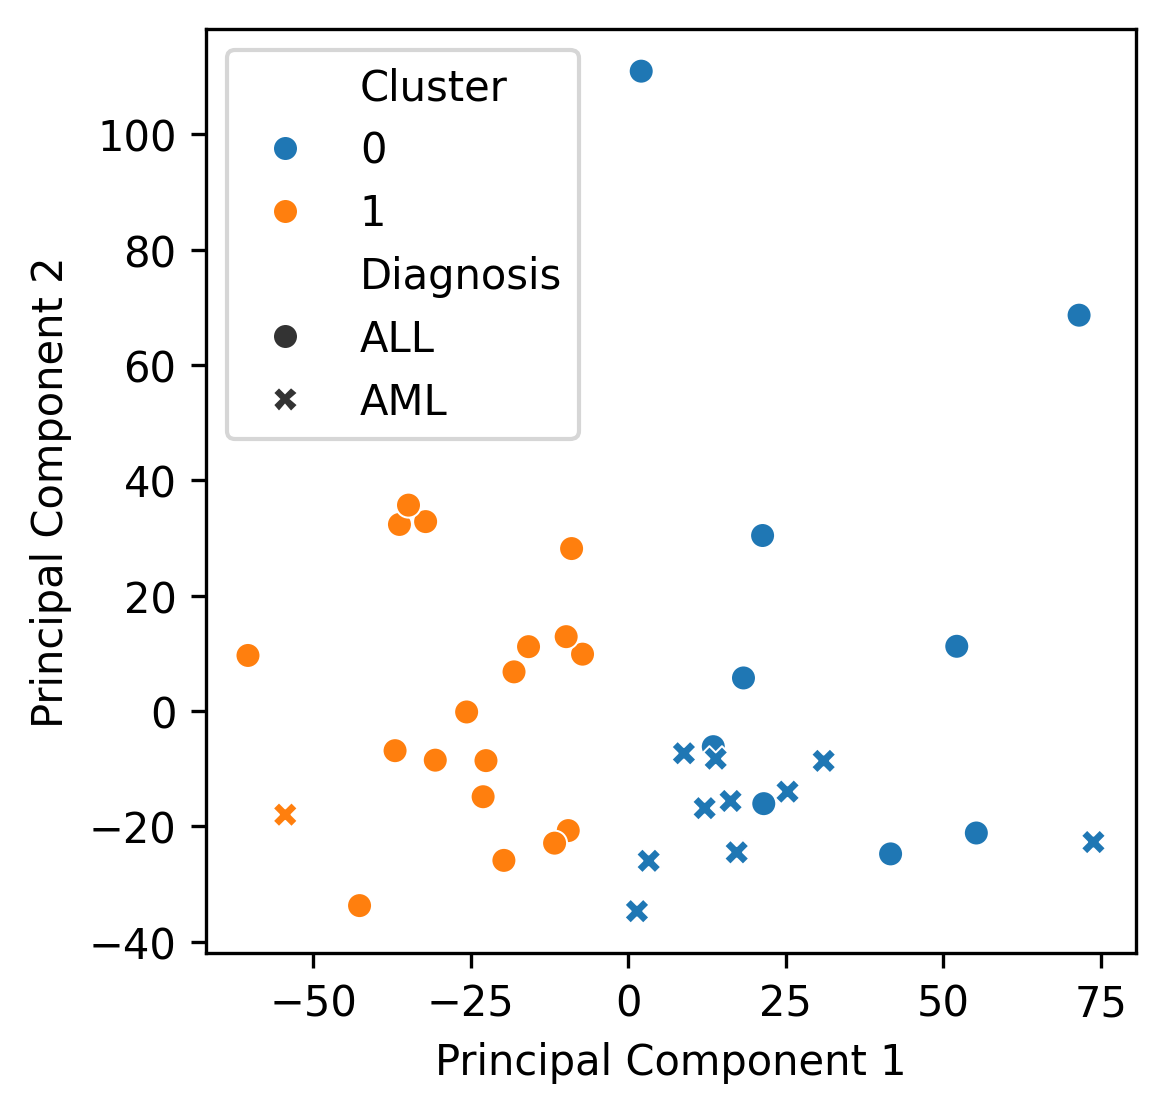

In [34]:
# 
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = sns.scatterplot(data=pc_df, x="PC_1", y="PC_2", hue="Cluster", style="Diagnosis")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
plt.show() 

This brings us to an important ability of unsupervised learning models; we don't need to confine ourselves to grouping datapoints into the 2 known clusters (AML and ALL)

We can also harness these models to group into more arbitrary clusters to reveal hidden associations and commonalities that may warrant valuable new research. This type of applied unsupervised learning is called class discovery. 

For illustrative purposes, we can tell a new Agglomerative Clustering model to create 4 instead of 2 groups and show this in a PCA scatterplot: 

In [80]:
clustering = AgglomerativeClustering(n_clusters=4).fit(features)
pc_df["Cluster"] = clustering.labels_.tolist()
print('Clustering Labels:\t', clustering.labels_)
print('Actual Labels:\t\t', labels)

Clustering Labels:	 [2 1 2 2 1 1 2 2 2 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 2 2 2 3 3 3 2 1 3 2 2
 3]
Actual Labels:		 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1]


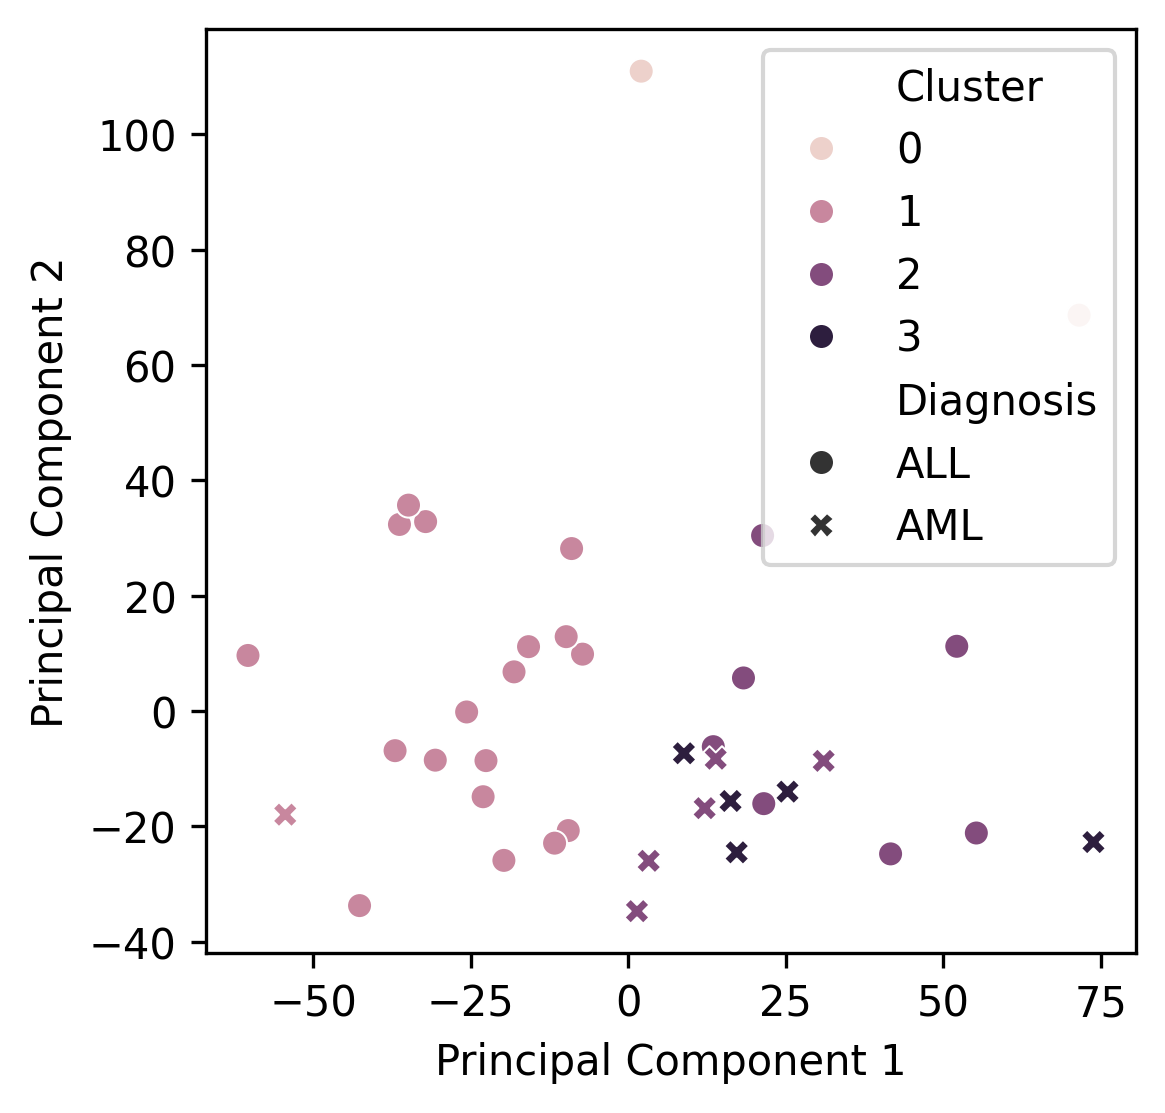

In [81]:
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = sns.scatterplot(data=pc_df, x="PC_1", y="PC_2", hue="Cluster", style="Diagnosis")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
plt.show() 

Notice how AML datapoints are mostly sorted into darker colored categories (2 and 3) while the ALL datapoints are mostly grouped into the lighter colored categories (0 and 1). While the models can't ascribe any clinical meaning to this behavior, cancer researchers can use this model's results as a catalyst for further investigation and even major discoveries.

## 5: Results, Analysis & Conclusion

In this lengthy foray into the world of cancer research, we got a comprehensive look at genomic expression data for acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL). We performed data cleaning, z-score normalization and t-tests to prepare our data for machine learning models, and also visualized the most expressed genes for each type of leukemia in a heatmap so we knew what the goal of our models would be. 

For the supervised learning phase of the project, we harnessed logistic regression to correctly classify AML and ALL genes by their expression data 97.37% of the time (and that is a lower bound because adding more genes to the training data yielded near perfect test scores). We also visualizes the prediction confidence, which also grew higher when more data was added to the models.

And within the unsupervised learning phase, we created, fitted, and tuned the hyperparameters of K-means clustering and agglomerative clustering, where it was revealed that K-means clustering, despite being simpler, was a better candidate for grouping top AML and ALL genes together without even knowing each datapoint's true label. 

There are plenty of potential expansions to this project. Perhaps the biggest constraint in this project is the rather limited clean data we had to work with. While the primary dataset had a substantial amount of genes, the secondary one (which outlined which were AML and which were ALL examples) had only 38 usable rows. More data would undoubtedly mitigate potential overfitting in the supervised learning sections, and give more robust clusters in the unsupervised learning section. Furthermore, there is plenty of exploration to do regarding more model choices in both sections, more expansive hyperparameter tuning for logistic regression in particular, and of course, more class discovery that could reveal hidden patterns within cancer genes that could open the door to more cancer research, a clear therapeutic target, and even a new treatment for AML, ALL, and more cancers. And while this is just a snapshot of applied unsupervised machine learning in cancer research, it captures the essence of an fight to beat cancer one treatment, experiment, ML model, and one datapoint at a time. 